# Assignment 2: Implementing a Linear Classifier from Scratch
 
*version 1, since this lab is new for 2020, details/bugs in this lab might be fixed within the first week of publication, you will be notified by email if this happens*
 
In this assignment, you explore the inner workings of a linear classifier pipeline. You will implement a classifier for a binary sentiment classification task to predict whether movie reviews are positive or negative. In most real world cases, you will have good (and relatively bug free) tools at your disposal. However, for being able to be creative with an ML problem, it is crucial to understand the inner workings of the full pipeline. You will therefore implement the key parts of the classifier, feature extraction and the learning algorithm. The parts you need to re-implement are marked "implementation task" in bold.
 
Your starting point for the assignment is an implementation of the full pipeline that uses scikit learn. If you find it useful, you can keep this code for comparison. The code provided takes care of some other practical details like downloading, extracting and loading the data.
 
## Submission
 
Please make your submission through Studentportalen in notebook format. You should include the following:
 
1. A working implementation of your pipeline, reproducing your principal results when executed.
2. Comments in the code for longer or opaque functionality. Please try to write self documenting code (e.g. by choosing descriptive variables names etc).
3. A brief description of the implementation work that was necessary to complete the different parts, showing how you arrived at your solution.
4. A table listing hyperparameter values you tested and the resulting scores (mean loss and mean accuracy) on the validation set. Clearly mark the hyperparameter settings you finally selected and the resulting scores on the test set. All scores should be found using 10-fold cross validation with a 10% validation set size (i.e. 1 test fold and 9 training/validation folds with 10% for validation). 
6. A short qualitative analysis of the final decision boundary (e.g. why did this word count negative etc).
7. Comments on what you thought was hard in the assignment, what you think was educational, what took most time and which parts might be unnecessary tricky.
 
The assignment must be solved by each student individually **or** in a pair (given the agreed upon restrictions in partner choice).
 
Apart from sections and titles, please remove all unnecessary text and code from the notebook you hand in. Keep only that which strengthens the case that you fulfill the listed requirements.
 
## Plagiarism
 
In code assignments, plagiarism is a tricky concept. A clean cut way would be to demand that you write all the code yourself, from memory, with only the assigned literature as help. However, this is not how code is developed professionally. It is common to copy and share. Since this is a learning exercise, you must try to implement everything on your own or in the pair, but please look at the course repo, stackoverflow etc, talk to course mates to find inspiration. As a part of the examination, you might be asked to explain any particular part of the core functionality in your implementation.

## Dataset: The sentiment polarity task

For this assignment, we use the [Review polarity v2.0](http://www.cs.cornell.edu/people/pabo/movie-review-data/) data set created by Bo Pang and Lillian Lee at Cornell University. It consists of 2000 movie reviews, 1000 of which are positive and 1000 are negative. The task is to predict, for an unseen review, whether it is positive or negative. This is a binary classification task.

The following downloads and extracts the dataset.

In [1]:
data_url = """http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz"""
fn = data_url.split("/")[-1]

import urllib.request
urllib.request.urlretrieve(data_url, fn)
!tar zxf review_polarity.tar.gz
!ls

poldata.README.2.0  review_polarity.tar.gz  sample_data  txt_sentoken


Always check the readme for information about a dataset.

In [2]:
!head -n15 poldata.README.2.0



Introduction

This README v2.0 (June, 2004) for the v2.0 polarity dataset comes from
the URL http://www.cs.cornell.edu/people/pabo/movie-review-data .


What's New -- June, 2004

This dataset represents an enhancement of the review corpus v1.0
described in README v1.1: it contains more reviews, and labels were
created with an improved rating-extraction system.


## Part 1: Reading the data

The following reads in the full dataset.

In [3]:
import os
filenames = list()
for root, dirs, files in os.walk("./txt_sentoken"):
   for name in files:
      filenames.append(os.path.join(root, name))
print("Found %i files" % len(filenames))

Found 2000 files


In [4]:
import numpy as np

X_txt = list()
y = list()
import random
random.shuffle(filenames)
for i, fn in enumerate(filenames):
  if fn.find("/pos/") > 0:
    msg = "positive"
    y.append(1)
  else:
    msg = "negative"
    y.append(-1)
  with open(fn) as f:
    X_txt.append(f.read())
  if i < 10:
    print(fn, msg, "example")

y = np.asarray(y)
assert len(X_txt) == y.shape[0]

./txt_sentoken/pos/cv565_29572.txt positive example
./txt_sentoken/neg/cv609_25038.txt negative example
./txt_sentoken/pos/cv671_5054.txt positive example
./txt_sentoken/neg/cv350_22139.txt negative example
./txt_sentoken/neg/cv917_29484.txt negative example
./txt_sentoken/pos/cv310_13091.txt positive example
./txt_sentoken/neg/cv710_23745.txt negative example
./txt_sentoken/neg/cv215_23246.txt negative example
./txt_sentoken/neg/cv205_9676.txt negative example
./txt_sentoken/neg/cv428_12202.txt negative example


Examining the loaded data, we can see how many data points are in the corpus. Below, you will find a histogram over the length of the reviews.

2000 documents in X_txt
2000 labels in y


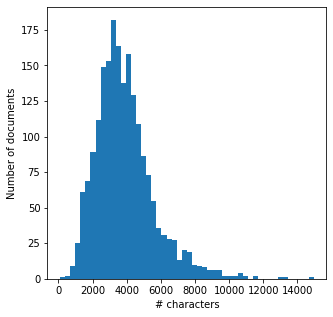

In [5]:
print("%i documents in X_txt" % len(X_txt))
print("%i labels in y" % len(y))

import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.hist([len(x) for x in X_txt], 50)
plt.ylabel("Number of documents")
plt.xlabel("# characters")
plt.show()

## Part 2: Feature extraction

As basic features, we use a binary bag-of-words (BOW) representation of the words in the review. Each review in the data set is described by a vector with one component corresponding to each word in the vocabulary. This component is set to 1 if the review contains this word, 0 otherwise.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X_txt)
X = vectorizer.transform(X_txt)
X[X>1] = 1
words = vectorizer.get_feature_names()

In the sklearn implementation above, the vectors are stored as a sparse matrix, (i.e. only the position and value of the non-zero elements are stored). However, the data set is small enough to encode the matrix X as a dense matrix.
 
**Implementation task:** You should re-implement the feature extraction in the code cell above. The list called words should contain the words for each feature dimension and X should contain the BOW binary vectors. X does not have to be sparse but is better implemented as a numpy array/matrix.
 
We can now look at the data and the words corresponding to feature dimensions.

In [7]:
print(words[2000:2010])
print(X[:10, 2000:2010].todense())
for w in ['dolphin', 'the', 'coffee']:
  print("'%s' in words: %s" %(w, w in words))

['anvil', 'anway', 'anxieties', 'anxiety', 'anxious', 'anxiously', 'any', 'anya', 'anybody', 'anyhoo']
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]
'dolphin' in words: True
'the' in words: True
'coffee' in words: True


At this point in the code, X and y are ready for the supervised learning task with logistic regression.

## Part 3: Learning framework 
 
The model we will use is logistic regression. This is a combination of a regression line approximating the labels that goes through a sigmoid function. These two functions together create a decision boundary through the data space, separating good from bad ratings.
 
**Implementation task:** You should implement your own versions of the following parts:
 
1. **Logistic regression predictor**. The model should be a linear regression within a sigmoid as $f(x)=\frac{1}{1+ e^{-\omega^\top x}}$. Note that $x_0$ in this notation is the pseudo input 1.
 
2. **Hinge and log loss**. You should implement the hinge ($\sum_i \max(0, 1-y_i \cdot \hat y_i)$) and logistic (or log) loss ($L_{\log}(y, \hat y) = \sum_i -(y_i \log (\hat y_i) + (1 - y_i) \log (1 - \hat y_i))$ ) functions. For the logistic loss, y must be in encoded as $\{0,1\}$.
 
3. **Gradient descent**. The update for gradient descent looks like $\omega^{(n+1)} = \omega^{(n)} - \gamma \nabla f(\omega^{(n)})$, where the update is defined as $\nabla f = \left ( \frac{\partial f}{\partial \omega_0}, \frac{\partial f}{\partial \omega_1}, \ldots, \frac{\partial f}{\partial \omega_n} \right )^\top$. The partial derivatives in the vector $\nabla f(\omega^{(n)})$ can be approximated using finite differences. This means that the quotients can be calculated as $\frac{\partial f}{\partial \omega_n} \approx \frac{f(\omega^{(n)}+h) - f(\omega^{(n)})}{h}$, where $h$ must be a vector in the numerator where $h_i = 0$ for all $i \neq n$ and $h_n = \epsilon \in \mathbb{R}$. The learning rate $\gamma \in \mathbb{R}$ acts as a dampening factor on the gradient update. The constant $\epsilon$ should be small. This should run until $\omega^{(t)}\approx \omega^{(t-1)}$.
 
4. **Regularisation**. Regularisation is simply adding a norm on the parameter vector and including that in the objective function. This can look like, for some objective function $g$, $g(X, \omega) = loss(f(X, \omega), y) + \beta \sum_{i=1}^n \omega_i^2$. The $l_1$ norm is defined as $\sum_{i=1}^n \omega_i$, for the $l_2$ norm one often uses only the squared version as $\sum_{i=1}^n \omega_i^2$. The regularisation always has some parameter $\beta \in \mathbb{R}$, keeping it from dominating the objective function.

In [8]:
from sklearn.linear_model import SGDClassifier

# Set hyperparameters (these variables are only here for clarity)
reguliser_dampening = 0.001
learning_rate = .1
regulariser = 'l2'
loss_function = 'hinge'

# Create the untrained classifier
model_verbose = SGDClassifier(loss=loss_function, penalty=regulariser,
                      alpha=reguliser_dampening, verbose=1,
                      learning_rate='constant', eta0=learning_rate)

# Train the classifier
model_verbose.fit(X, y)

-- Epoch 1
Norm: 32.28, NNZs: 23011, Bias: -0.002000, T: 2000, Avg. loss: 1.634847
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 34.24, NNZs: 26608, Bias: 0.000000, T: 4000, Avg. loss: 0.529886
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 32.47, NNZs: 27918, Bias: -0.003000, T: 6000, Avg. loss: 0.210650
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 30.61, NNZs: 28785, Bias: -0.001000, T: 8000, Avg. loss: 0.149150
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 28.66, NNZs: 29297, Bias: -0.001000, T: 10000, Avg. loss: 0.085735
Total training time: 0.02 seconds.
-- Epoch 6
Norm: 27.97, NNZs: 29874, Bias: -0.003000, T: 12000, Avg. loss: 0.129618
Total training time: 0.02 seconds.
-- Epoch 7
Norm: 27.06, NNZs: 30331, Bias: -0.002000, T: 14000, Avg. loss: 0.115752
Total training time: 0.02 seconds.
-- Epoch 8
Norm: 28.02, NNZs: 30846, Bias: -0.004000, T: 16000, Avg. loss: 0.147452
Total training time: 0.02 seconds.
-- Epoch 9
Norm: 28.23, NNZs: 31315, Bias: -0.002000,

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=True,
              l1_ratio=0.15, learning_rate='constant', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=1, warm_start=False)

In the above training with verbose=1, note how the loss etc are changing. For your implementation, it can be very good to print out lots of information so that you can see if you get what you expect (e.g. a lowering of the loss).
 
We can examine the weights by plotting them. Think about how to interpret these weights.

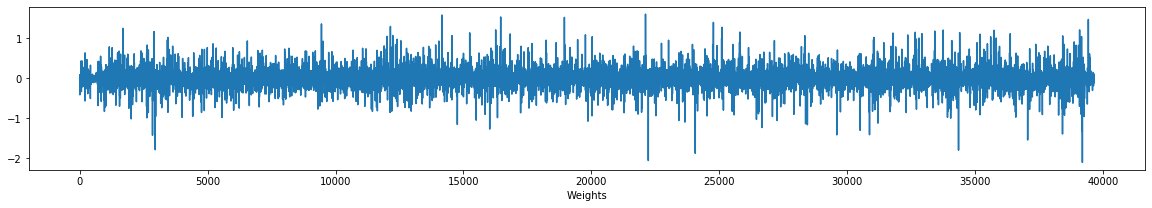

In [9]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(20, 3))
plt.plot(model_verbose.coef_.ravel())
plt.xlabel("Value")
plt.xlabel("Weights")
plt.show()

From the same information, we can plot the words with the strongest influence.

In [10]:
# Pick out the weight vector
w = model_verbose.coef_.ravel()

# Sort by absolute value
idx = np.argsort(np.abs(w))

print("                Word   Weight  Occurences")
for i in idx[-20:]:
  print("%20s   %.3f\t%i " % (words[i], w[i], np.sum([words[i] in d for d in X_txt])))

                Word   Weight  Occurences
                ever   1.294	1791 
                save   -1.298	312 
               worse   -1.320	211 
            deserves   1.357	108 
              wasted   -1.389	112 
              others   1.395	378 
              script   -1.408	632 
          ridiculous   -1.412	159 
               awful   -1.420	156 
                 yet   1.468	478 
                 job   1.520	480 
           hilarious   1.530	191 
       unfortunately   -1.539	329 
                 fun   1.579	956 
           memorable   1.601	131 
                 bad   -1.782	825 
            supposed   -1.793	321 
             nothing   -1.871	594 
                mess   -2.052	315 
               worst   -2.098	238 


## Exploring hyperparameters
 
For optimisation of the hyperparameters, sklearn provides code for doing both data splits and random search on a grid. First, a parameter distribution needs to be defined (this is in the code below). The ```ParameterSampler``` class lets you sample from the distribution.
 
Following the current consensus in ML methodology, we will split of a test set before exploring any configuration and use this data only at the very end of the experiment. The training data is first split in 10 folds. Then the classifier is trained on 9 training folds and evaluated on the 10:th validation fold.
 
#### You should experiment with the following hyperparameters:
 
1. **Learning rate**. Try different settings of the learning rate. It is useful to pick values from an exponentially spaced grid, e.g. 0.0001/0.0003/0.001/0.003/0.01/0.03/0.1/0.3/1.0/3.0, where each of the values is about 3 times as large as the previous one. Note what happens when the learning rate gets too large. Try to find a learning rate that is as large as possible, but still reliable.
 
2. **Regularisation**. Implement l1 regularisation and l2
regularisation. Try both of them and test different values for the regularisation strength. An exponentially spaced grid is recommended here as well. Keep an eye on the performance of the classifier as well as (for a few runs) the weight histogram.
 
3. **Regulariser dampening**. Try to find how much the regulariser needs to be dampened to get a good score.
 
4. **Loss function.** Evaluate both logistic loss and hinge loss. Try out both of them and see how they affect the results. Note that the loss values computed by the two methods are not comparable, so you should use other metrics such as accuracy to compare models between the two. The optimal learning rate may be different depending on what type of loss you use.
 
For the real valued hyperparameters, add extra points if you find a promising interval. Note that trying every combination of hyperparameters is likely not feasible, but don't hesitate to try.
 
Once you’ve settled on a final set of hyperparameters that work well (and only then!), use the test set and rerun to obtain a score on the test set.

In [0]:
from sklearn.model_selection import KFold, train_test_split, ParameterSampler

# Define the parameters
parameter_distribution = {'loss_function': ['hinge', 'log'],
                          'learning_rate': np.exp(np.linspace(np.log(0.0001), np.log(3), 10)),
                          'reguliser_dampening': np.exp(np.linspace(np.log(0.0001), np.log(3), 10)),
                          'regulariser': ['l2', 'l1']}
# Splitting of the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1)

# Placeholder to make fututre comparissons easier
best_hyperparameters = None

In [12]:
for hyperparameters in ParameterSampler(parameter_distribution, n_iter=4):
  # The output from the for loop as a dictionary with hyperparameters
  print(hyperparameters)

  # Set up the classifier
  reguliser_dampening = hyperparameters['reguliser_dampening']
  learning_rate = hyperparameters['learning_rate']
  regulariser = hyperparameters['regulariser']
  loss_function = hyperparameters['loss_function']
  model = SGDClassifier(loss=loss_function, penalty=regulariser,
                        alpha=reguliser_dampening, verbose=0,
                        learning_rate='constant', eta0=learning_rate)
  
  # Run cross validation
  validation_accuracy = list()
  for train, val in KFold(n_splits=10, shuffle=True).split(X):
    X_train = X[train]
    y_train = y[train]
    X_val = X[val]
    y_val = y[val]
    model.fit(X_train, y_train)
    validation_accuracy.append(np.sum(model.predict(X_val)==y_val)/len(y_val))

  # Calculate the mean accuracy    
  mean_validation_accuracy = np.mean(validation_accuracy)

  # Store the hyperparameters if they are better than what we have found before
  if best_hyperparameters is None or best_hyperparameters[1] < mean_validation_accuracy:
    best_hyperparameters = (hyperparameters, mean_validation_accuracy)
  print("Mean validation accuracy: %.1f%%" % (100*mean_validation_accuracy))

{'reguliser_dampening': 0.0003143821771531824, 'regulariser': 'l1', 'loss_function': 'hinge', 'learning_rate': 0.0009883615331157487}
Mean validation accuracy: 84.7%
{'reguliser_dampening': 0.009768585201429125, 'regulariser': 'l1', 'loss_function': 'log', 'learning_rate': 0.00310723250595386}
Mean validation accuracy: 77.7%
{'reguliser_dampening': 0.009768585201429125, 'regulariser': 'l2', 'loss_function': 'log', 'learning_rate': 0.30353265475060387}
Mean validation accuracy: 67.2%
{'reguliser_dampening': 0.030710690833316446, 'regulariser': 'l2', 'loss_function': 'hinge', 'learning_rate': 0.30353265475060387}
Mean validation accuracy: 65.0%


**Implementation task:** Implement code for printing a sorted table of your sampled hyperparameters. You are allowed to use modules written by others. In order to do this, you must change the code above to store your evaluations (with mean loss/accuracy) of different hyperparameters sets.

The final code call below evaluates the estimated best hyperparameter set on the test set.

In [13]:
reguliser_dampening = best_hyperparameters[0]['reguliser_dampening']
learning_rate = best_hyperparameters[0]['learning_rate']
regulariser = best_hyperparameters[0]['regulariser']
loss_function = best_hyperparameters[0]['loss_function']

# Set up the classifier
model = SGDClassifier(loss=loss_function, penalty=regulariser,
                      alpha=reguliser_dampening, verbose=0,
                      learning_rate='constant', eta0=learning_rate)

# Train on all the non-test data
model.fit(X_train_val, y_train_val)

# Run prediction on the test set
test_set_accuracy = np.sum(model.predict(X_test)==y_test)/len(y_test)

print("Final accuracy %.1f%%" % (100*test_set_accuracy))

Final accuracy 83.5%


Is this a good result? What is a good result? For a qualitative analysis, you can use the word list and weight plot from above.

## VG assignment
 
To achieve a pass with distinction (VG) in this assignment, you must solve the tasks above without serious errors. In addition, you must implement momentum, RMSProp and a [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) feature model. Since this is an "easy" problem for SGD, don't expect the extensions to improve the result much. For tf-idf, you can choose your prefered formulation from the literature, but please motivate it in a few sentences. The new classifier and features should be included in the comparison.